To do list : check each model + word2vec + chinese tokenization

In [2]:
import gensim
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

import matplotlib.pyplot as plt 

from sklearn.pipeline import Pipeline
#from sklearn.externals import joblib

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (done)/NLP_for_onedrive')
from NLP_function import *
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (done)/NLP_for_onedrive/In_Database')

#######################################################################################

# Compare Models

In [ ]:
df = pd.read_excel('C:/Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (done)/NLP_for_onedrive/cli.tokenizing_all_hpo.xlsx')
df.head()

In [ ]:
X,Y = read_dataset('C:/Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (done)/NLP_for_onedrive/cli.tokenizing_jy_train.csv', index=102, lan='en')

vectorizer  = CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 10))
transformer = TfidfTransformer()

X = vectorizer.fit_transform(X)
X_tfidf = transformer.fit_transform(X)

# print(X.toarray()[0].shape)
print('number of features:',X_tfidf.toarray()[0].shape[0])
print('number of sample:', len(X_tfidf.toarray()))

In [27]:
# a supprimer 
vectorizer  = CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 10))
transformer = TfidfTransformer()

Df = pd.read_csv('C:/Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (done)/NLP_for_onedrive/Data_Prepare/Training_data_final.csv', encoding='ANSI')
Df['x_cn'][0] = 'congenital unilateral vas deferens'
Df['x_cn'][1] = 'obstructive azoospermia'
Df['x_cn'][2] = 'complex heart disease'

x=vectorizer.fit_transform(Df['x_cn'].iloc[0:3,])

print(vectorizer.get_feature_names())

['azoospermia', 'complex', 'complex heart', 'complex heart disease', 'congenital', 'congenital unilateral', 'congenital unilateral vas', 'congenital unilateral vas deferens', 'deferens', 'disease', 'heart', 'heart disease', 'obstructive', 'obstructive azoospermia', 'unilateral', 'unilateral vas', 'unilateral vas deferens', 'vas', 'vas deferens']


<ipython-input-27-7819b1c673a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df['x_cn'][0] = 'congenital unilateral vas deferens'
<ipython-input-27-7819b1c673a8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df['x_cn'][1] = 'obstructive azoospermia'
<ipython-input-27-7819b1c673a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df['x_cn'][2] = 'complex heart disease'


training SGD


C:\Users\Jingz\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


training ASGD
training Perceptron
training Passive-Aggressive I
training Passive-Aggressive II
training SAG


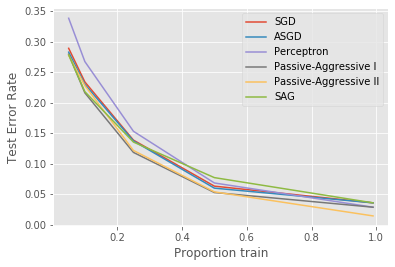

In [102]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds  = 20

classifiers = [
    #("SGD", SGDClassifier(max_iter=100)), 
    ("ASGD", SGDClassifier(average=True)), 
    ("Perceptron", Perceptron()), 
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge', C=1.0, tol=1e-4)),
    #("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge', C=1.0, tol=1e-4)), 
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / X.shape[0])) 
    
    
   #('NB', MultinomialNB()),                        
   #("Nearest Neighbors", KNeighborsClassifier(3)), 
    ("Linear SVM", SVC(kernel="linear", C=0.025)),  
   #('RBF SVM', SVC(gamma=2, C=1)),                 
   #('Gaussian Process', GaussianProcessClassifier(1.0 * RBF(1.0))),   
   #('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)),   
   #("Decision Tree", DecisionTreeClassifier(max_depth=5)), 
    ("Neural Net", MLPClassifier(alpha=1, max_iter=1000)),  
   # ("AdaBoost", AdaBoostClassifier()), 
   # ("QDA", QuadraticDiscriminantAnalysis())     
    
]

xx = 1. - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
            train_test_split(X, Y, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_)) 
    plt.plot(xx, yy, label=name)
    
plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

#######################################################################################

# Import and Split

In [5]:
X,Y = read_dataset('C:/Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/NLP_for_onedrive/cli.tokenizing_jy_train.csv', index=102, lan='en')
print(Y.value_counts().head())

cleaned x_en[index]: testicular volume normal left 17 ml right 15 ml.
cleaned y_en[index]: normal
abnormality testis size                                213
female external genitalia individual 46xy karyotype    123
normal                                                 114
abnormal vas deferens morphology                        57
reduced sperm motility                                  45
Name: y_en, dtype: int64


['absence secondary sex characteristics', 'absent vas deferens', 'reduced sperm motility', 'infertility', 'azoospermia', 'abnormality testis size', 'obstructive azoospermia', 'normal', 'abnormal sperm morphology', 'atretic vas deferens', 'abnormal vas deferens morphology', 'abnormal spermatogenesis', 'female external genitalia individual 46xy karyotype', 'abnormal sperm motility', 'noun', 'polycystic ovaries', 'sperm head anomaly']


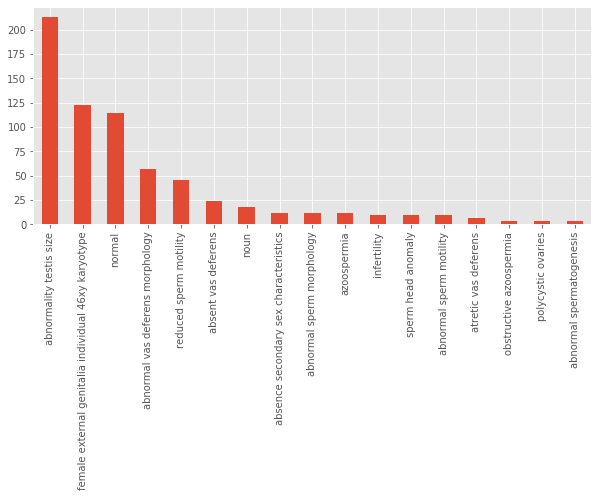

In [6]:
my_tags = pd.unique(Y).tolist()
print(my_tags)
plt.figure(figsize=(10,4))
Y.value_counts().plot(kind='bar')

Imbalanced Classes obseved. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. 
Undersampling or oversampling each class can solve the problem.

In [109]:
# Split data into train and test

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state = 42)
my_tags = pd.unique(y_test).tolist()

print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape, 'x_test shape:', x_test.shape, 'y_test shape:', y_test.shape)
print('levels of y_test :', len(pd.unique(y_test))) 
print('levels of y_train :', len(pd.unique(y_train))) 

x_train shape: (470,) y_train shape: (470,) x_test shape: (202,) y_test shape: (202,)
levels of y_test : 15
levels of y_train : 17


# Fit models

### (soft-margin) Linear Support Vector Machine

In [41]:
sgd = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                #('hash', HashingVectorizer(n_features=2**6)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None)),
               ])
sgd.fit(x_train, y_train)

y_pred = sgd.predict(x_test)
my_tags = pd.unique(y_test).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.995049504950495
                                                     precision    recall  f1-score   support

                            abnormality testis size       1.00      1.00      1.00         4
                             reduced sperm motility       1.00      1.00      1.00         2
                                             normal       1.00      1.00      1.00         1
female external genitalia individual 46xy karyotype       1.00      1.00      1.00        18
                                        infertility       1.00      0.99      0.99        68
              absence secondary sex characteristics       1.00      1.00      1.00         2
                   abnormal vas deferens morphology       1.00      1.00      1.00         8
                                               noun       1.00      1.00      1.00         2
                                absent vas deferens       1.00      1.00      1.00         2
                                        az

##### Confusion-Matrix

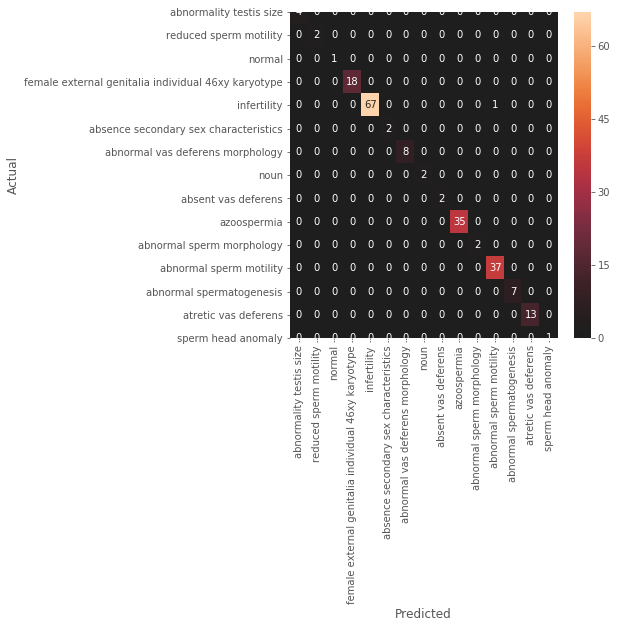

In [12]:
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=y_test.drop_duplicates().values, yticklabels=y_test.drop_duplicates().values,
            center=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### save model

In [13]:
with open('M_SGDClassifier.pickle', 'wb') as handle:
    pickle.dump(sgd, handle, protocol=pickle.HIGHEST_PROTOCOL)  

### Logistic Regression

In [54]:
logreg = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)
my_tags = pd.unique(y_pred).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.995049504950495
                                                     precision    recall  f1-score   support

                            abnormality testis size       1.00      1.00      1.00         4
                             reduced sperm motility       1.00      1.00      1.00         2
                                             normal       1.00      1.00      1.00         1
female external genitalia individual 46xy karyotype       1.00      1.00      1.00        18
                                        infertility       1.00      0.99      0.99        68
              absence secondary sex characteristics       1.00      1.00      1.00         2
                   abnormal vas deferens morphology       1.00      1.00      1.00         8
                                               noun       1.00      1.00      1.00         2
                                absent vas deferens       1.00      1.00      1.00         2
                                        az

C:\Users\Jingz\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


##### save model

In [15]:
with open('M_LogisticRegression.pickle', 'wb') as handle:
    pickle.dump(logreg, handle, protocol=pickle.HIGHEST_PROTOCOL)  

### Passive Aggressive Classifier

In [106]:
PacI = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                ('tfidf', TfidfTransformer()),
                ('clf',   PassiveAggressiveClassifier(loss='hinge', C=1.0, tol=1e-4)),
               ])
PacI.fit(x_train, y_train)


PacII = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                ('tfidf', TfidfTransformer()),
                ('clf',   PassiveAggressiveClassifier(loss='squared_hinge', C=1.0, tol=1e-4)),
               ])
PacII.fit(x_train, y_train)


y_pred = PacII.predict(x_test)
my_tags = pd.unique(y_pred).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.995049504950495
                                                     precision    recall  f1-score   support

                            abnormality testis size       1.00      1.00      1.00         4
                             reduced sperm motility       1.00      1.00      1.00         2
                                             normal       1.00      1.00      1.00         1
female external genitalia individual 46xy karyotype       1.00      1.00      1.00        18
                                        infertility       1.00      0.99      0.99        68
              absence secondary sex characteristics       1.00      1.00      1.00         2
                   abnormal vas deferens morphology       1.00      1.00      1.00         8
                                               noun       1.00      1.00      1.00         2
                                absent vas deferens       1.00      1.00      1.00         2
                                        az

##### save model

In [107]:
with open('M_PassiveAggressiveClassifierII.pickle', 'wb') as handle:
    pickle.dump(PacII, handle, protocol=pickle.HIGHEST_PROTOCOL)  

### Naive Bayes Classifier for Multinomial Models

In [19]:
nb = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1,4))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
my_tags = pd.unique(y_test).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names = my_tags))

accuracy 0.8811881188118812
                                                     precision    recall  f1-score   support

                            abnormality testis size       1.00      0.50      0.67         4
                             reduced sperm motility       0.00      0.00      0.00         2
                                             normal       0.00      0.00      0.00         1
female external genitalia individual 46xy karyotype       0.90      1.00      0.95        18
                                        infertility       0.91      0.99      0.94        68
              absence secondary sex characteristics       1.00      1.00      1.00         2
                   abnormal vas deferens morphology       1.00      1.00      1.00         8
                                               noun       0.00      0.00      0.00         2
                                absent vas deferens       0.00      0.00      0.00         2
                                        a

C:\Users\Jingz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [23]:
rf = Pipeline([('vect', CountVectorizer(max_df=100, min_df=0,ngram_range=(1, 4))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)),
               ])
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
my_tags = pd.unique(y_test).tolist()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.693069306930693
                                                     precision    recall  f1-score   support

                            abnormality testis size       0.00      0.00      0.00         4
                             reduced sperm motility       0.00      0.00      0.00         2
                                             normal       0.00      0.00      0.00         1
female external genitalia individual 46xy karyotype       1.00      0.67      0.80        18
                                        infertility       0.52      1.00      0.69        68
              absence secondary sex characteristics       0.00      0.00      0.00         2
                   abnormal vas deferens morphology       1.00      0.88      0.93         8
                                               noun       0.00      0.00      0.00         2
                                absent vas deferens       0.00      0.00      0.00         2
                                        az

C:\Users\Jingz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#######################################################################################

# Load pretrained model and predict

In [33]:
with open('M_SGDClassifier.pickle', 'rb') as handle:
    sgd= pickle.load(handle)
with open('M_LogisticRegression.pickle', 'rb') as handle:
    logreg= pickle.load(handle)
    

y_pred = sgd.predict(x_test)
i=93
print(i, 'Predicted_class:', y_pred[i], '; Real_class:', y_test.iloc[i])

y_pred = logreg.predict(x_test)
print(i, 'Predicted_class:', y_pred[i], '; Real_class:', y_test.iloc[i])

93 Predicted_class: female external genitalia individual 46xy karyotype ; Real_class: female external genitalia individual 46xy karyotype
93 Predicted_class: female external genitalia individual 46xy karyotype ; Real_class: female external genitalia individual 46xy karyotype


##############################################################################################

# Pretrained embedding

### Word2vec and Logistic Regression

learn feature representations for words

In [ ]:
os.chdir('C://Users/Jingz/OneDrive/CarrierGene/2019.07.10-HPO (en cours)/')

from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("NLP_python\Embedding\Word2Vec\GoogleNews-vectors-negative300.txt", binary=False)
wv.init_sims(replace=True)

In [ ]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

In [ ]:
# BOW average method

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['y_en'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

## Doc2vec and Logistic Regression

learn feature representations for sentences or documents

In [ ]:
https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
    
    
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df.x_en, df.y_en, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
all_data[:2]